In [1]:
import numpy as np
import gzip
import itertools
from pathlib import Path
import os, sys
import re
import matplotlib.pyplot as plt
import arviz as az
%matplotlib inline 

In [3]:
#want to load up the chain of parameter values.
#this is stored in the P1-GMO-point.mc.gz file, 
#which holds an array of (n x m x [p+1]) values,
#where p is the number of parameters,
#n is the number of samples explored per walker,
#and m is the number of walkers.
#the first parameter stored is the -ve log likelihood of the parameters.

Q = [] 
with gzip.open(os.path.join(os.getcwd(), 'P1-adv-point.mc.gz'), 'rt') as f: #defines the list 'files' as f and opens each file in the list and then closes it automatically#This block initialises a load of lists and variables that are used in the main for loop.
    file_content = f.read()
    splitted = file_content.splitlines()
    print(splitted[0])
    for line in itertools.islice(splitted, 1, None):
        list2 = line.strip(' ').strip('\n').split(' ')
        list3 = [float(i) for i in list2]
        Q.append((list3))

# logp point (Nthin x Npop x Nvar = [5264,190,19])


In [4]:
from uravu.distribution import Distribution

In [5]:
Qarray = np.array(Q)
print(Qarray.shape) #now we have all the samples per parameter in an array.

(1000160, 20)


In [6]:
#create a list of names for each parameter.

names = [
        'logl',
        'P1_hdod Bkg',
        'P1_hdod I0',
        'h_dod_1 interface',
        'Adv_h interface',
        'Adv rho',
        'Adv_solv',
        'Adv_h thickness',
        'FeOx_rough',
        'FeOx_thick',
        'Fe_rough',
        'Fe_thick',
        'SiOx thickness',
        'P1_ddod Bkg',
        'P1_ddod I0',
        'd_dod_1 rho',
        'FeOx rho',
        'FeOx_m',
        'Fe rho',
        'Fe_magmom'
        ]

In [7]:
variables = []
for i in range (1, Qarray.shape[1]):
    variables.append(Distribution(Qarray[:, i], name=names[i], ci_points=(2.5, 97.5))) #16, 84 #2.5, 97.5

In [8]:
#calculate rhat & number of independent samples.
#discard first parameter - nll

#must be in shape of (chains, steps, pars) for arviz.
Qarray_reshape = np.reshape(Qarray, (int(Qarray.shape[0]/5264), 5264, Qarray.shape[-1]))[:, :, 1:]

#method 1 - via arviz
rhat = az.rhat(az.convert_to_dataset(Qarray_reshape))
print(rhat.to_array())

ess = az.ess(az.convert_to_dataset(Qarray_reshape))
print(ess.to_array())

<xarray.DataArray (variable: 1, x_dim_0: 19)>
array([[1.00090795, 1.0014636 , 1.0011389 , 1.0017383 , 1.00170299,
        1.00135538, 1.00161254, 1.00111473, 1.00181145, 1.00123089,
        1.00128523, 1.00111964, 1.00099815, 1.00128827, 1.00088733,
        1.00118759, 1.00125517, 1.00143492, 1.00128527]])
Coordinates:
  * x_dim_0   (x_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * variable  (variable) <U1 'x'
<xarray.DataArray (variable: 1, x_dim_0: 19)>
array([[ 991312.87055098,  982251.3482312 ,  995362.6933383 ,
         987580.16368431,  976445.60311305,  993999.36400653,
         980396.26652733,  985070.85871114,  974685.7580719 ,
         998398.90546014,  995348.39349685,  991708.96488044,
         991174.20465625, 1002510.87050068,  997920.1929558 ,
         985269.12303018,  986957.69288422,  986926.56183617,
         996562.9839262 ]])
Coordinates:
  * x_dim_0   (x_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * variable  (variable) <U1 'x'


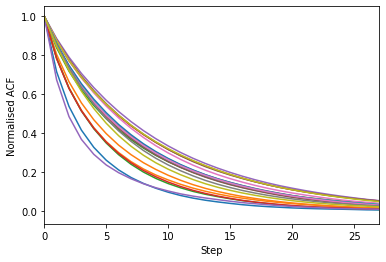

In [9]:
#should we trust ess here? Would suggest there is no correlation between samples.

#reshape array so it maches refnx standard.
Qarray_reshape_scp = np.reshape(Qarray, (int(Qarray.shape[0]/190), 190, Qarray.shape[-1]))[:, :, 1:]

from refnx.analysis.curvefitter import autocorrelation_chain

#now lets plot average acf of each chain for each parameter.
plt.plot(autocorrelation_chain(Qarray_reshape_scp))
plt.xlim(0, 27)
plt.xlabel('Step')
plt.ylabel('Normalised ACF')
plt.show()

#conclusion - don't think arviz estimate is accurate here.

In [10]:
#method 2 - use refnx's (emcee's) autocorrelation time function + custom rhat function.

def gelman_rhat(sequences, portion=0.5):
    """
    A modification of bumps.dream.gelman function (which only uses last portion of each chain), 
    to match that proposed in Gelman et al (Bayesian data analysis) 2013 pg 281.
    """

    # Find the size of the sample
    chain_len, nchains, nvar = sequences.shape #(steps, nwalkers, ndim) - this follows refnx fitter.chain shape.
    
    # Only use the last portion of the sample
    chain_len_index = int(chain_len*portion) #portion splits the chain in the middle. 
    #we want to compare first half to latter half.
    
    sequences_last = sequences[-chain_len_index:] #last section of chain
    sequences_first = sequences[:chain_len_index] #first section of chain
    #if odd number of total samples, then we miss out the middle sample...
    
    tot_seq = np.concatenate((sequences_first, sequences_last), axis=1) #add these together so the number of chains 
    #doubles and samples per split chain stays the same.
    
    if chain_len < 2:
        # Set the R-statistic to a large value
        r_stat = -2 * ones(nvar)
    else:
        n = tot_seq.shape[0] #n is length of each chain.
        m = tot_seq.shape[1] #m is number of split chains.
        
        #first lets calc B:
        
        # Step 1: Determine the sequence means
        mean_seq = np.mean(tot_seq, axis=0)
        
        # Step 2: Determine B. This step calculates the mean_of_means and calculates the variance. 
        # ddof=1 applies (m - 1) to the dividing factor. Thus the scale factor at the start is n/m-1.
        B = n*np.var(mean_seq, axis=0, ddof=1)
        
        #Now lets calc W:
        
        # Step 3: Calculate s_j^2, the variance in each chain.
        Sj = np.var(tot_seq, axis=0, ddof=1)
        
        # Step 4: Calculate W.
        W = np.mean(Sj, axis=0)
        
        #Now to calculate sigma2 & then Rhat.
        
        #Step 5: Now lets calculate sigma^2:
        sigma2 = ((n-1)/n)*W + (1/n)*B
        
        Rhat = np.sqrt(sigma2/W)
        
        return Rhat

In [11]:
#check rhat for each parameter. Around 1.0 is ideal.
print(gelman_rhat(Qarray_reshape_scp))

from refnx.analysis import integrated_time

# calculate emcee autocorrelation time for each parameter.
# describes how many more samples required for walker to forget where it was. 
tau = integrated_time(Qarray_reshape_scp, quiet=True)
print(f'Correlation takes between {np.min(tau):.1f} and {np.max(tau):.1f} steps to reduce to near 0')

#estimate number of independent samples.
Neff = (Qarray_reshape_scp.shape[0]*Qarray_reshape_scp.shape[1])/tau #number of samples divided by tau
print(f'Minimum number of independent samples is esimated to be {np.min(Neff):.0f}')

[1.00127286 1.00211273 1.00262374 1.00331169 1.00330696 1.00335565
 1.00298031 1.00237996 1.00328362 1.0024616  1.0024045  1.00181121
 1.00152613 1.001722   1.00137538 1.00226429 1.00225643 1.00261852
 1.00247572]
Correlation takes between 7.9 and 17.8 steps to reduce to near 0
Minimum number of independent samples is esimated to be 56091


In [12]:
#print out the statistics that describe each parameter.

import scipy

alpha = 0.001
for i, j in enumerate(variables):
    print(f"""{variables[i].name}
    Median: {j.n:.3E}
    Lower: {j.con_int[0]:.3E}
    Upper: {j.con_int[1]:.3E}
    Minus: {j.n-j.con_int[0]:.3E}
    Plus: {j.con_int[1]-j.n:.3E}
    Is gauss?: {'Yes' if scipy.stats.normaltest(j.samples)[1] >= alpha else 'No'}
    Gauss_test_p: {scipy.stats.normaltest(j.samples)[1]:.3E}
    MCSE_median: {az.mcse(j.samples, method="quantile", prob=0.5):.3E}
    MCSE_lb: {az.mcse(j.samples, method="quantile", prob=0.025):.3E}
    MCSE_ub: {az.mcse(j.samples, method="quantile", prob=0.975):.3E}""")

P1_hdod Bkg
    Median: 6.821E-06
    Lower: 5.922E-06
    Upper: 7.707E-06
    Minus: 8.990E-07
    Plus: 8.862E-07
    Is gauss?: No
    Gauss_test_p: 6.852E-21
    MCSE_median: 5.436E-10
    MCSE_lb: 1.241E-09
    MCSE_ub: 1.261E-09
P1_hdod I0
    Median: 9.407E-01
    Lower: 9.323E-01
    Upper: 9.490E-01
    Minus: 8.327E-03
    Plus: 8.349E-03
    Is gauss?: Yes
    Gauss_test_p: 2.758E-03
    MCSE_median: 5.600E-06
    MCSE_lb: 1.184E-05
    MCSE_ub: 1.305E-05
h_dod_1 interface
    Median: 2.538E+00
    Lower: 1.069E+00
    Upper: 5.232E+00
    Minus: 1.469E+00
    Plus: 2.695E+00
    Is gauss?: No
    Gauss_test_p: 0.000E+00
    MCSE_median: 1.717E-03
    MCSE_lb: 4.064E-04
    MCSE_ub: 3.054E-03
Adv_h interface
    Median: 3.100E+00
    Lower: 1.099E+00
    Upper: 5.489E+00
    Minus: 2.001E+00
    Plus: 2.389E+00
    Is gauss?: No
    Gauss_test_p: 0.000E+00
    MCSE_median: 1.987E-03
    MCSE_lb: 6.269E-04
    MCSE_ub: 2.260E-03
Adv rho
    Median: 2.210E-01
    Lower: -4.96